In [1]:
import os.path

import gensim.downloader as api
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from gensim.models.keyedvectors import *
from keras import Sequential, Model
from keras.callbacks import *
from keras.layers import *
from keras.utils.data_utils import get_file
from tensorflow.python.data.ops import dataset_ops
from official.nlp import optimization
import tensorflow_text

In [2]:
SEQUENCE_LENGTH = 300
DENSE_SIZE = 16
DROP_OUT = 0.2

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [4]:
def to_pandas(data: dataset_ops.PrefetchDataset):
    result = pd.DataFrame(data.as_numpy_iterator(), columns=('text', 'label'))
    result['text'] = result['text'].map(lambda val: val.decode("utf-8"))
    return result.copy()

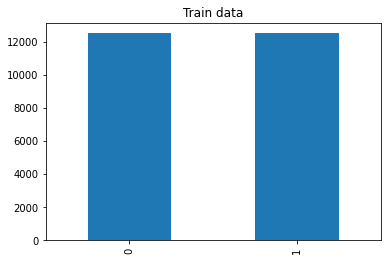

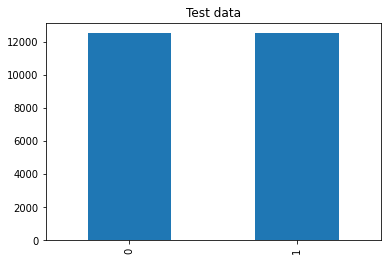

In [5]:
# Отобразим выобрку данных

train_dataset = to_pandas(train_dataset)
test_dataset = to_pandas(test_dataset)

train_dataset["label"].value_counts().sort_index().plot.bar()
plt.title("Train data")
plt.show()

test_dataset["label"].value_counts().sort_index().plot.bar()
plt.title("Test data")
plt.show()

In [28]:
def download_model(url, file_name, model_name):
    return os.path.dirname(get_file(file_name, url, extract=True, cache_dir='.',
                                    cache_subdir=f'model{os.path.sep}{model_name}', archive_format='zip'))

In [29]:
# Модель нейронной сети

def get_model(encode_layer, weights, name, trainable):
    model = Sequential(name=name)
    model.add(encode_layer)

    with tf.device('cpu:0'):
        embedding_layer = Embedding(input_dim=encode_layer.vocabulary_size(), output_dim=weights.shape[1],
                                    mask_zero=True, trainable=trainable, weights=[weights])
        embedding_layer.build(input_shape=[])

    model.add(embedding_layer)
    if trainable:
        model.add(Dropout(DROP_OUT))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(DENSE_SIZE, activation="relu"))
    model.add(Dropout(DROP_OUT))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    model.summary()
    return model


In [30]:
# Glove 840 billion, 300 vector

dir_glove = download_model('http://nlp.stanford.edu/data/glove.840B.300d.zip', 'glove.840B.300d.zip.tar.gz', 'glove840B')
vector_glove = pd.read_csv(f'{dir_glove}{os.path.sep}glove.840B.300d.txt', header=None, sep=' ',
                           quoting=csv.QUOTE_NONE).dropna().drop_duplicates(subset=[0])
encoder_glove = TextVectorization(vocabulary=vector_glove[0], input_shape=[], output_sequence_length=SEQUENCE_LENGTH)

In [31]:
weights = vector_glove.iloc[:, 1:].to_numpy()
weights = np.concatenate((np.zeros((2, weights.shape[1])), weights), axis=0)

In [32]:
model_glove = get_model(encoder_glove, weights, 'glove6B', False)

model_glove.fit(train_dataset['text'].to_numpy(), train_dataset['label'].to_numpy(),
                epochs=10,
                batch_size=32,
                validation_data=(test_dataset['text'].to_numpy(), test_dataset['label'].to_numpy()))

del model_glove
del weights
del vector_glove
del encoder_glove

Model: "glove6B"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 300)          658803000 
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_8 (Dense)             (None, 16)                4816      
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17  

In [33]:
# Word2Vec, Google news, 300 vector

vector_word2vec: Word2VecKeyedVectors = api.load("word2vec-google-news-300")
encoder_word2vec = TextVectorization(vocabulary=np.array(list(vector_word2vec.vocab.keys())), input_shape=[], output_sequence_length=SEQUENCE_LENGTH)

In [34]:
weights = np.concatenate((np.zeros((2, vector_word2vec.vectors.shape[1])), vector_word2vec.vectors), axis=0)

model_word2vec = get_model(encoder_word2vec, weights, 'word2vec', False)

model_word2vec.fit(train_dataset['text'].to_numpy(), train_dataset['label'].to_numpy(),
                   epochs=10,
                   batch_size=32,
                   validation_data=(test_dataset['text'].to_numpy(), test_dataset['label'].to_numpy()))

del weights
del vector_word2vec
del encoder_word2vec
del model_word2vec

Model: "word2vec"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 300, 300)          900000600 
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 16)                4816      
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17 

In [6]:
# BERT

BER_ENCODER = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2' #tfhub_handle_encoder
BERT_PREPROCESS = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3' #tfhub_handle_preprocess

def get_bert_model(name, preprocess, encoder, trainable, optimizer='adam'):
    preprocessor = hub.load(preprocess)

    input = Input(shape=(), dtype=tf.string)
    tokenized_input = hub.KerasLayer(preprocessor.tokenize)(input)
    encoder_inputs =   hub.KerasLayer(preprocessor.bert_pack_inputs, arguments=dict(seq_length=SEQUENCE_LENGTH))([tokenized_input])

    encoding = hub.KerasLayer(encoder, trainable=trainable)(encoder_inputs)
    net = encoding['pooled_output']

    if trainable:
        net = Dropout(DROP_OUT)(net)

    dense = Dense(DENSE_SIZE, activation="relu")(net)
    dropout = Dropout(DROP_OUT)(dense)
    result = Dense(1, activation="sigmoid")(dropout)

    model = Model(input, result, name=name)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    model.summary()
    return model

In [7]:
num_train_steps = 782 * 10
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

adamw = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [37]:
model_bert = get_bert_model('BERT', BERT_PREPROCESS, BER_ENCODER, False, 'adam')

model_bert.fit(train_dataset['text'].to_numpy(), train_dataset['label'].to_numpy(),
                epochs=10,
                batch_size=32,
                validation_data=(test_dataset['text'].to_numpy(), test_dataset['label'].to_numpy()))

del model_bert

Model: "BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_12 (KerasLayer)    (None, None, None)   0           ['input_5[0][0]']                
                                                                                                  
 keras_layer_13 (KerasLayer)    {'input_mask': (Non  0           ['keras_layer_12[0][0]']         
                                e, 300),                                                          
                                 'input_type_ids':                                                
                                (None, 300),                                                   

In [8]:
model_bert = get_bert_model('BERT-trainable', BERT_PREPROCESS, BER_ENCODER, True, adamw)

model_bert.fit(train_dataset['text'].to_numpy(), train_dataset['label'].to_numpy(),
                epochs=10,
                batch_size=32,
                validation_data=(test_dataset['text'].to_numpy(), test_dataset['label'].to_numpy()))

del model_bert

Model: "BERT-trainable"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_mask': (Non  0           ['keras_layer[0][0]']            
                                e, 300),                                                          
                                 'input_type_ids':                                                
                                (None, 300),                                         